## Predict cab fare


In [1]:
import sys
#Change path to wherever you place this project
sys.path.append('C:\\Users\\PAT\\Documents\\edwisor\\projects\\cab_fare')

#Do all imports
from cab_fare import *
from cab_fare.config import *
from utils import *
from utils.utils_ import *


Using TensorFlow backend.


In [2]:
data = pd.read_csv(train_data_path,parse_dates=['pickup_datetime'])
test = pd.read_csv(test_data_path,parse_dates=['pickup_datetime'])

full_data = [data,test]



In [3]:
data.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0


In [4]:
#Size of dataset and testset
data.shape,test.shape

((16067, 7), (9914, 6))

In [5]:
data.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

#### Although passenger count is numeric in dataset, actually it has a fewer values, and hence it is not  continous but rather a discrete variable.
- but for calculation ease, let us keep numeric and later convert to catgerical(type str/object)
- However it wont serve any purpose to see mean,median or other statistics like 25%,75%, so label it under catgerical tag(See below)

In [6]:
continous_names, cat_names, iv,dv,testparams = iv_dv_get_col_names_dist_based(data,'fare_amount')
continous_names, cat_names

Need to define this col - passenger_count in categ variable


(['pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude',
  'passenger_count'],
 ['fare_amount', 'pickup_datetime'])

# Univariate analysis

## i. fare_amount
- datatype conversions

fare_amount is an object type, and has non-numeric characters , so lets make it numeric
#### Negative values
- 2 values have negative sign
- negative sign is placed after a number has no significance, may be by mistake, so lets ignore those

In [7]:
#before, notice minus sign in fare amount
data.iloc[1123]

fare_amount                             430-
pickup_datetime      2009-09-22 19:01:01 UTC
pickup_longitude                    -73.9796
pickup_latitude                      40.7713
dropoff_longitude                   -73.9758
dropoff_latitude                      40.782
passenger_count                            1
Name: 1123, dtype: object

In [8]:
#clean fare amount and convert to float
data.fare_amount = clean_num(data,data.fare_amount,'fare_amount')
data.fare_amount= data.fare_amount.astype('float')

############# these observations decrease our model performance, and since they were negative, so deleting
#drop these indexes of negative fares
data = data.drop([1123,2039,2486,13032]).reset_index().drop('index',axis=1)






fare has these values with - sign
430- : 1123
-2.9 : 2039
-2.5 : 2486
-3 : 13032


In [10]:
data[data.fare_amount<=1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2777,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1.0
9999,0.00,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1.0


#### may be these rides had a pass applied, but they will confuse our model, let remove

In [11]:
#Remove rides with fare amount<=1
data = data.drop(data[data.fare_amount<=1].index)
#Reset the indexes
data = data.reset_index().drop('index',axis=1)

### Missing value analysis


In [12]:
print_missing_val_summary(full_data)

Missing values exist in train
No Missing values in  test


### Missing value percentages
We need to see percentage wise and drop column if >30% is missing

In [13]:
full_data = [data,test]
missing_per = {}
missing_per = get_missing_val_per(full_data,missing_per)


In [14]:
#See missing percentages
print('-----------train------------')
print(missing_per['Train'][missing_per['Train']['missing_per']>0].head())
print('-----------test------------')
print(missing_per['Test'][missing_per['Test']['missing_per']>0].head())

-----------train------------
                 missing_per
fare_amount         0.149430
passenger_count     0.342444
-----------test------------
Empty DataFrame
Columns: [missing_per]
Index: []


#### How to impute?

- Since the missing percentage is less than 30%, we will impute then one by one

### Missing value analysis for fare_amount

In [15]:
data.fare_amount.mean(),data.fare_amount.median(),data.fare_amount.mode()


(15.020208891937237, 8.5, 0    6.5
 dtype: float64)

#### MEAN/MEDIAN/MODE?
mean is greater than median, it is right skewed data(since majority is lying on the right hand side tail), so we choose between median/mode
But in fare, generally mean is better metrics, and since data is right skewed,
- lets choose median as it is nearer to the  mean and would give better representation of the fare


### distribution of fare?

In [16]:
pd.qcut(data.fare_amount,5).value_counts()


(1.139, 5.5]       3325
(9.5, 14.1]        3262
(5.5, 7.3]         3216
(14.1, 54343.0]    3151
(7.3, 9.5]         3083
Name: fare_amount, dtype: int64

#### let's see how many are beyond 100

In [17]:
len(data[data.fare_amount>100]),len(data[data.fare_amount>150]),len(data[data.fare_amount>200]),\
len(data[data.fare_amount>500])

(9, 6, 4, 2)

In [18]:
data[data.fare_amount>500]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1015,54343.0,2015-02-27 17:03:50 UTC,-74.003319,40.727455,-73.964470,40.764378,1.0
1072,4343.0,2012-01-15 20:42:04 UTC,-73.976309,40.751634,-74.014854,40.709044,1.0


#### That's really high
we cant say until we know if there the cab was rented out for a few days (on a long trip may be).
But without that info, we need to delete these high fares

### How fare looks like?

(-847.5001521057864, 877.571070639136)

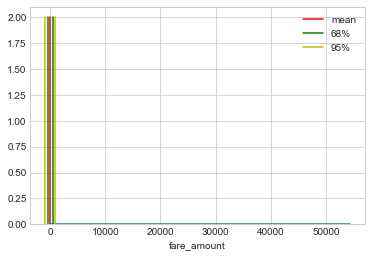

In [19]:
min_95_per , _,_,max_95_per = plot_dist(data.dropna().fare_amount)
min_95_per,max_95_per
# That looks quite very pointy and very narrow(skewed) distribution

Text(0.5, 1.0, 'Distribution of Trip Fare')

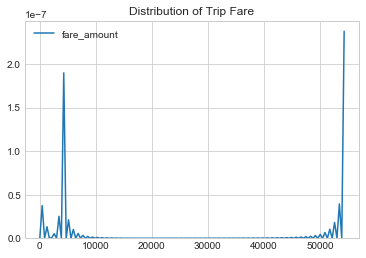

In [20]:
sb.kdeplot(data['fare_amount']).set_title("Distribution of Trip Fare")

In [21]:
data.fare_amount.isnull().sum()

24

In [22]:
# Imputation
data.fare_amount = data.fare_amount.fillna(data.fare_amount.median())
full_data =[data,test]

In [23]:
# Just get the oulier info
outlier = []
outlier,data= get_outliers(data,['fare_amount'],outliers_=outlier,drop=False)
full_data = [data,test]

-----values below -3.75 and above 22.25 suggested to drop for col fare_amount:


---------------original---------------
Skewness :  125.46681874636782
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  15834.507324588294
^^^^^^^^Flat
---------------log---------------
Skewness :  1.0791639691577823
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  4.051503796895485
^^^^^^^^Flat
---------------sqrt---------------
Skewness :  73.61266848970753
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  7575.92453931639
^^^^^^^^Flat
---------------cbrt---------------
Skewness :  17.939577578454784
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  1040.1472328292882
^^^^^^^^Flat


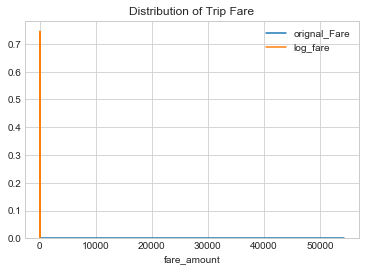

In [24]:
#plt.subplot(320)
_ =sb.kdeplot(data['fare_amount'],label='orignal_Fare').set_title("Distribution of Trip Fare")
#plt.subplot(321)
_=sb.kdeplot(np.log(data['fare_amount']),label='log_fare').set_title("Distribution of Trip Fare")
distribution_summary(data.fare_amount,'fare_amount')

#### This is because of those outliers in fare, 
- not deleting for now, will plot them against year and see if it makes any sense

## ii. passenger_count

###  Missing value analysis for passenger_count
- datatype conversions

max passenger count can at max 10, let's say you are driving a mini van, but beyond that, it looks odd 

### plot with passenger count <10

Text(0.5, 1.0, 'Histogram for passenger_count<=6')

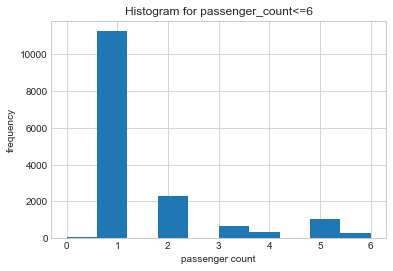

In [25]:
data[data['passenger_count']<=6]['passenger_count'].hist()
plt.ylabel('frequency')
plt.xlabel('passenger count')
plt.title('Histogram for passenger_count<=6')

Text(0.5, 1.0, 'passenger count < 6')

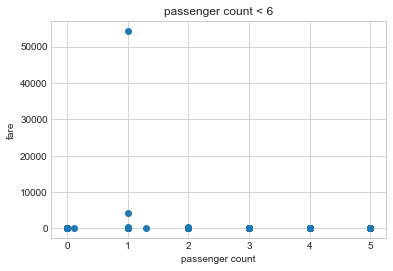

In [26]:
tmp = data[data.passenger_count<6]
plt.scatter(tmp.passenger_count, tmp.fare_amount)
plt.ylabel('fare')
plt.xlabel('passenger count')
plt.title('passenger count < 6')

#### fare distribution passengers_count = 6
passenger_count max is 6, under the count of 10, so let us see the fare paid

(5.5, count    302.000000
 mean      11.447252
 std        7.866293
 min        3.300000
 25%        6.100000
 50%        9.000000
 75%       14.000000
 max       57.540000
 Name: fare_amount, dtype: float64)

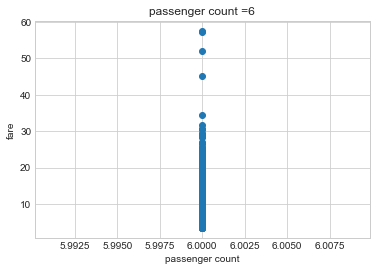

In [27]:
tmp = data[data.passenger_count==6]
plt.scatter(tmp.passenger_count,tmp.fare_amount)
plt.ylabel('fare')
plt.xlabel('passenger count')
plt.title('passenger count =6')
tmp.fare_amount.mode()[0],tmp.fare_amount.describe()

#### Median
since fares are right skewed, median will be better approach

### If passenger_count is > 10, then are these records overall bad ones?

Text(0.5, 1.0, 'Count plot for passenger count >6')

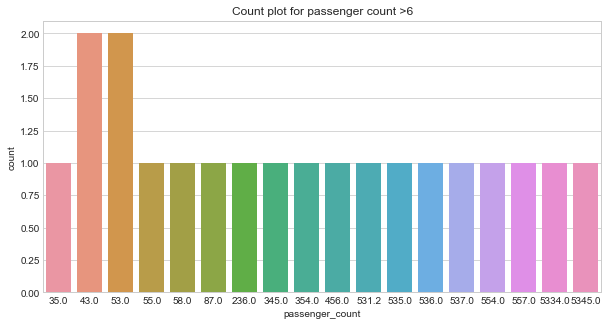

In [28]:
#Lets see the frequencies
f,ax= plt.subplots(figsize=(10,5))
sb.countplot(data[data.passenger_count>6]['passenger_count'])
plt.title("Count plot for passenger count >6")

(8.5, count    20.000000
 mean      8.070000
 std       3.670666
 min       3.700000
 25%       5.600000
 50%       8.050000
 75%       8.800000
 max      20.000000
 Name: fare_amount, dtype: float64)

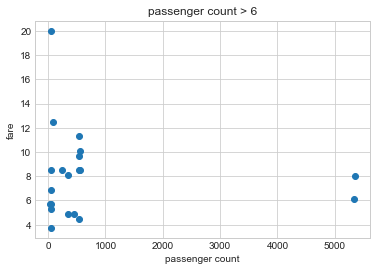

In [29]:
tmp_gr_10 = data[data.passenger_count>6]
plt.scatter(tmp_gr_10.passenger_count, tmp_gr_10.fare_amount)
plt.ylabel('fare')
plt.xlabel('passenger count')
plt.title('passenger count > 6')
tmp_gr_10.fare_amount.mode()[0],tmp_gr_10.fare_amount.describe()

In [30]:
len(tmp_gr_10)

20

#### FINDING
The average fare paid by these absurd observations is almost normally distributed with mean,median,mode lying closely to each other, with a max of 20
- Even if we want to keep these rows, we need to see what passenger_count did rides with average fare of 8 had?



In [31]:
#print(data[data.fare_amount.between(8,9)]['passenger_count'].value_counts())
#clearly 1 is the winner here
data[data.fare_amount.between(8,9)]['passenger_count'].mode()[0]

1.0

In [32]:
#### if drop
#data = data.drop(data[(data.passenger_count>6)|(data.passenger_count<1)].index).reset_index().drop('index',axis=1)
#test = test.drop(test[(test.passenger_count>6)|(test.passenger_count<6)].index).reset_index().drop('index',axis=1)

Text(0.5, 0, 'passenger count')

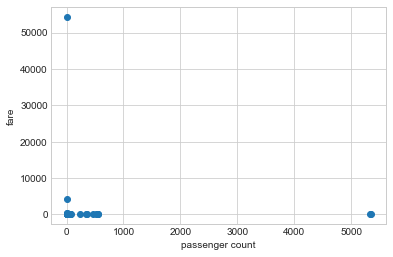

In [33]:
plt.scatter(data.passenger_count, data.fare_amount)
plt.ylabel('fare')
plt.xlabel('passenger count')

#### FINDING
passenger counts are fixed, but still some outliers in fare

## iii. pickup_datetime

In [34]:
bk=data.copy()

In [35]:
# pickup_datetime is timestamp object in test, but in train it is a string
# let us convert it
data = parsedate(data,'pickup_datetime')#parse the string in timestamp format



Invalid pickup time for 1326


Text(0.5, 1.0, 'with outliers in fares')

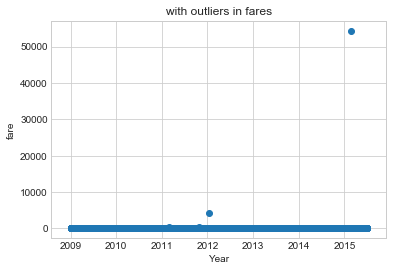

In [36]:
x = []
y = []
for i in range(len(data)):
    x.append(data.pickup_datetime[i].date() )
    y.append(data.fare_amount[i] )
               
plt.scatter(x,y)
plt.ylabel('fare')
plt.xlabel('Year')
plt.title('with outliers in fares')

####  Pretty flat line with a few outliers in fare, let's remove outliers

In [37]:
#remove outliers
outlier = []
outlier,data= get_outliers(data,['fare_amount'],outliers_=outlier,drop=True)
full_data = [data,test]

-----values below -3.75 and above 22.25 dropped  for col fare_amount:


Text(0.5, 1.0, 'with outliers removed in fares')

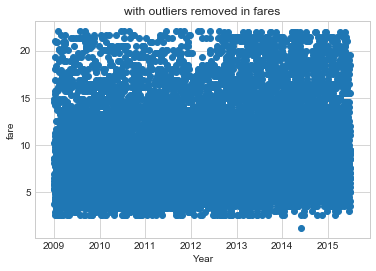

In [38]:
x = []
y = []
for i in range(len(data)):
    x.append(data.pickup_datetime[i].date() )
    y.append(data.fare_amount[i] )
               
plt.scatter(x,y)
plt.ylabel('fare')
plt.xlabel('Year')
plt.title('with outliers removed in fares')

#### Now they are close to each other 

Text(0.5, 1.0, 'fare_amount distribution')

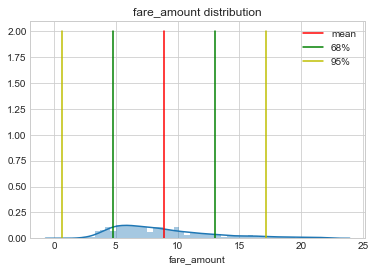

In [39]:
min_95_per , _,_,max_95_per = plot_dist(data.dropna().fare_amount)
min_95_per,max_95_per
plt.title('fare_amount distribution')
# That looks very flat and skewed towards right

---------------original---------------
Skewness :  1.0347767819388258
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  0.579255195867495
^^^^^^^^Flat
---------------log---------------
Skewness :  0.10555077332946282
%%%%%Moderately symm
Kurtosis :  -0.5185444366546967
~~~~~~~~~~Pointy
---------------sqrt---------------
Skewness :  0.5812531754955005
+++++very Right/positive(tail/majority towards right) skewed
Kurtosis :  -0.2432489302330345
%%%%%%%%%Moderately Bell shaped
---------------cbrt---------------
Skewness :  0.42589341019903754
%%%%%Moderately symm
Kurtosis :  -0.4030161188415837
%%%%%%%%%Moderately Bell shaped


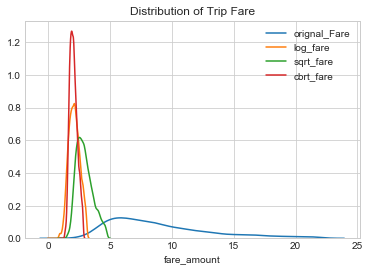

In [40]:
#plt.subplot(320)
_ =sb.kdeplot(data['fare_amount'],label='orignal_Fare').set_title("Distribution of Trip Fare")
#plt.subplot(321)
_=sb.kdeplot(np.log(data['fare_amount']),label='log_fare').set_title("Distribution of Trip Fare")
_=sb.kdeplot(np.sqrt(data['fare_amount']),label='sqrt_fare').set_title("Distribution of Trip Fare")
_=sb.kdeplot(np.cbrt(data['fare_amount']),label='cbrt_fare').set_title("Distribution of Trip Fare")
distribution_summary(data.fare_amount,'fare_amount')

### Feature Engineering
Get some more insights from pickup_date and store it under 'time' column

In [41]:
#Derive info from pickup timestamp

full_data = feature_eng([data,test])
data = full_data[0]
test=full_data[1]

In [42]:
data.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,remarks,time,day,month,year,weekday,season
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0,normal,peakeveningtime,15.0,6.0,2009.0,0.0,summer
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0,normal,noontime,5.0,1.0,2010.0,1.0,winter


peakeveningtime    4320
noontime           4069
peaknighttime      3253
regular            3022
Name: time, dtype: int64

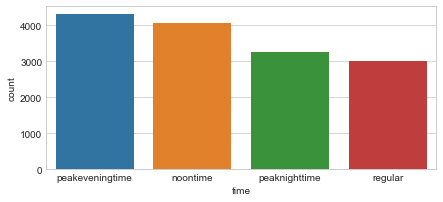

In [43]:
f,ax=plt.subplots(figsize=(7,3))
sb.countplot(data.time)
data.time.value_counts()

#### Mostly normal daytime rides and no weekend rides

In [44]:
## Derive new cols
bk=data.copy()

### How were the Fares for these times?

time
noontime           8.774426
peakeveningtime    8.875833
peaknighttime      9.422465
regular            8.546006
Name: fare_amount, dtype: float64
remarks
month_end      8.900203
month_start    9.436013
normal         8.880230
Name: fare_amount, dtype: float64


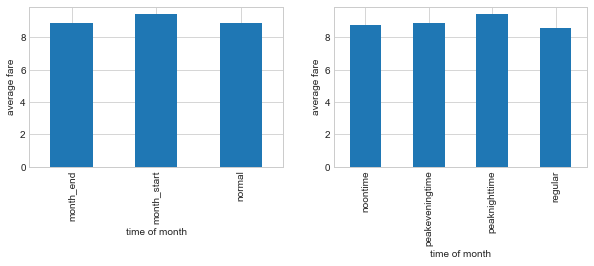

In [45]:
#f,ax=plt.subplots(figsize=(7,5))
print(data.groupby('time')['fare_amount'].mean())
print(data.groupby('remarks')['fare_amount'].mean())
plotno=324
plt.figure(figsize=(10,10))
plt.subplot(plotno)
_=data.groupby('time')['fare_amount'].mean().plot.bar()
plt.xlabel('time of month')
plt.ylabel('average fare')
plotno+=1
plt.subplot(plotno-2)
_=data.groupby('remarks')['fare_amount'].mean().plot.bar()
plt.xlabel('time of month')
plt.ylabel('average fare')
plt.show()


In [46]:
data.groupby('time')['fare_amount'].mean().nlargest(7)

time
peaknighttime      9.422465
peakeveningtime    8.875833
noontime           8.774426
regular            8.546006
Name: fare_amount, dtype: float64

#### what did we notice?
- Month_start recorded the highest average fare, followed by month_end, but overall they are very close, showing less significance on fare price
- Peak night time recorded highest average fare in a day as expected and it is quite significantly larger than others groups, showing night hours will impact the fares



## iv. Geographic coordinates(pickup_latitude and pickup_longitude)
distance is calculated latitude(N,S),longitude(E,W) pairs and since these are in decimals (not degree), - represent west

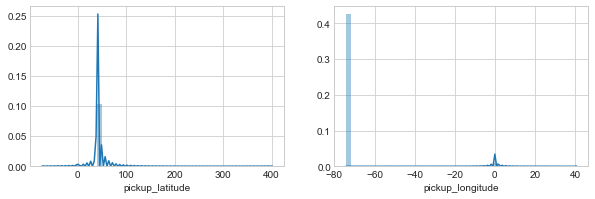

In [47]:
plotno=321
plt.figure(figsize=(10,10))
plt.subplot(plotno)

var = '_%s'%plotno
var = sb.distplot(data.loc[:,'pickup_latitude'])
plotno+=1
plt.subplot(plotno)
var = sb.distplot(data.loc[:,'pickup_longitude'])
plt.show()

In [48]:
full_data=[data,test]
data = clean_coord(data) #clean invalid coordinates(outside -90 to 90)
full_data[0] = data

full_data=calculate_dis(full_data)#calulate distnce
#full_data=dis(full_data)#calulate distnce
data=full_data[0]
test=full_data[1]

### Manhattan vs Euclidian
Mahattan distance is calculated when we have a mix of conitinous and categorical variables, whereas eucudian distance is the shortest distance between 2 points and hence can be used when you have only continous variables

Let us calculate all possible distances and see which one has the most corrleation with fare price(explaining the fare price the most)

#  Bi-variate analysis between different frames

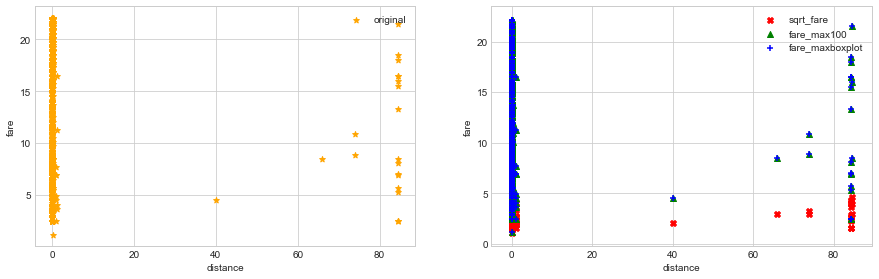

<Figure size 432x288 with 0 Axes>

In [49]:
#Let us plot relation between dis and price in all three frames, which we derived so far
df_fare_max100 = data[data.fare_amount<100]
df_fare_sqrt = data.copy()
df_fare_sqrt.fare_amount = np.sqrt(df_fare_sqrt.fare_amount)
df_fare_boxplot = data[data.fare_amount<22.5]

f,ax= plt.subplots(figsize=(15,15))
plotno=324
plt.subplot(plotno)
plt.scatter(df_fare_sqrt['euclid_dis'], df_fare_sqrt.fare_amount, marker='X',color='red',label='sqrt_fare')
plt.scatter(df_fare_max100['euclid_dis'], df_fare_max100.fare_amount, marker='^',color='green',label='fare_max100')
plt.scatter(df_fare_boxplot['euclid_dis'], df_fare_boxplot.fare_amount, marker='+',color='blue',label='fare_maxboxplot')
plt.legend(loc='upper right')
plt.xlabel('distance')
plt.ylabel('fare')
plt.subplot(323)
#original dataset
plt.scatter(data['euclid_dis'], data.fare_amount, marker='*',color='orange',label='original')
plt.legend(loc='upper right')
plt.xlabel('distance')
plt.ylabel('fare')

plt.show()
plt.savefig('../data/processed/scatter_var0.png',bbox_inches='tight')

In [50]:
bk = data.copy()
#data=bk.copy()
data.head(1)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,remarks,time,day,month,year,weekday,season,mahattan_dis,euclid_dis,geodesic
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1.0,normal,peakeveningtime,15.0,6.0,2009.0,0.0,summer,0.011742,0.009436,0.639764


#### let us get 1 frame with passenger_count>10 removed in df_cleaned
- Replace mode of passenger_count who has same average as the sub dataframe with passenger_count =0 in original dataframe

In [51]:
# Impute passenger_count
#data=bk.copy()
test = test.drop(test[(test.passenger_count<1)|(test.passenger_count>6)].index)
df_cleaned = data.drop(data[data.passenger_count>6].index)#delete
data.loc[(data.passenger_count>6)|(data.passenger_count>6),'passenger_count'] = 1 # dont delete

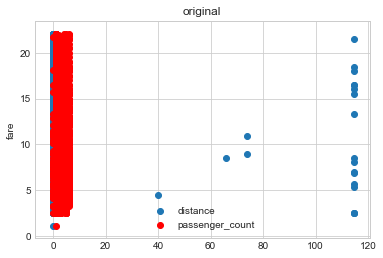

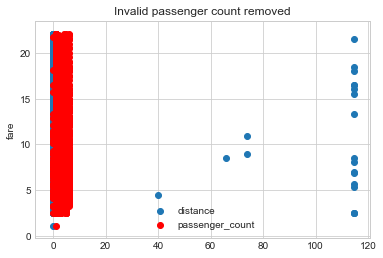

In [52]:
plot_rides(data,'original')
plot_rides(df_cleaned,'Invalid passenger count removed')

#### investigate passenger count > 6

In [53]:
#plt.scatter(bad_pass_count.geodesic,bad_pass_count.fare_amount)
#### shall we delete?
data[(data.fare_amount>6)&(data.fare_amount<8)].passenger_count.mode()

0    1.0
dtype: float64

In [54]:
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,weekday,mahattan_dis,euclid_dis,geodesic
fare_amount,1.000000,-0.011931,0.008549,-0.015383,0.012609,0.015539,-0.009661,0.024437,0.141993,0.017357,0.019966,0.019515,0.019631
pickup_longitude,-0.011931,1.000000,-0.983852,0.966092,-0.954622,-0.006736,-0.000962,-0.000593,-0.015755,0.001487,0.130673,0.126710,0.129355
pickup_latitude,0.008549,-0.983852,1.000000,-0.951989,0.972716,0.007404,-0.001578,0.001530,0.011878,-0.001941,-0.122699,-0.118973,-0.121462
dropoff_longitude,-0.015383,0.966092,-0.951989,1.000000,-0.977573,-0.005952,-0.001678,-0.001352,-0.014970,0.003926,0.114271,0.119365,0.115159
dropoff_latitude,0.012609,-0.954622,0.972716,-0.977573,1.000000,0.005527,-0.001009,0.002043,0.011368,-0.004179,-0.088768,-0.087544,-0.089885
passenger_count,0.015539,-0.006736,0.007404,-0.005952,0.005527,1.000000,0.001838,0.014668,0.003488,0.047039,-0.005550,-0.005778,-0.005315
day,-0.009661,-0.000962,-0.001578,-0.001678,-0.001009,0.001838,1.000000,-0.018836,-0.026613,0.009940,0.017435,0.016963,0.017349
month,0.024437,-0.000593,0.001530,-0.001352,0.002043,0.014668,-0.018836,1.000000,-0.116028,-0.017315,-0.015454,-0.015348,-0.015432
year,0.141993,-0.015755,0.011878,-0.014970,0.011368,0.003488,-0.026613,-0.116028,1.000000,0.005550,0.017208,0.016596,0.016927
weekday,0.017357,0.001487,-0.001941,0.003926,-0.004179,0.047039,0.009940,-0.017315,0.005550,1.000000,-0.008419,-0.007581,-0.007910


#### notice very less correlation of fare with distances(euclid/manahattan/geodesic), it is because of the outliers

### fractional values exist in passenger_count
- need to round off the passenger count and convert the data type to string, since it is a categorical variable actually

In [55]:
#Impute
data.loc[(data.passenger_count<1)|(data.passenger_count>6), 'passenger_count'] = 1
data.passenger_count = np.ceil(data.passenger_count)
df_cleaned.passenger_count = np.ceil(df_cleaned.passenger_count)
test.passenger_count = np.ceil(test.passenger_count)

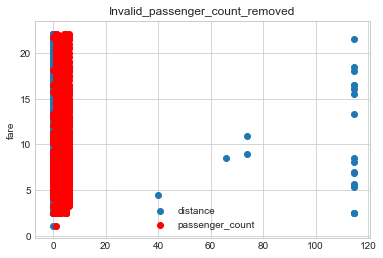

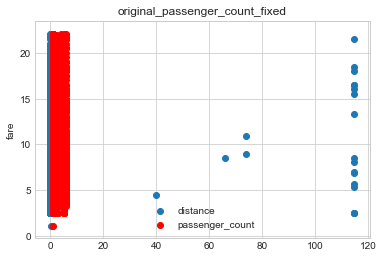

In [56]:
plot_rides(df_cleaned,'Invalid_passenger_count_removed')   
plot_rides(data,'original_passenger_count_fixed')


#### what does it tell?
- passenger count is very densely distributed(since only a few value values it can take)
- distance is having a few outliers


## for more distance also the price is same as the lesser distancees, may be the passenger count varies(check below)


In [57]:
data.loc[(data.passenger_count<1)|(data.passenger_count>6), 'passenger_count'] = 1

In [58]:
data.shape,df_cleaned.shape

((14663, 17), (14643, 17))

### how many rows with zero values in coordinates?

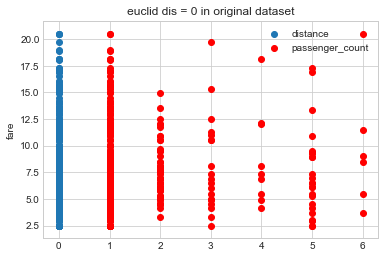

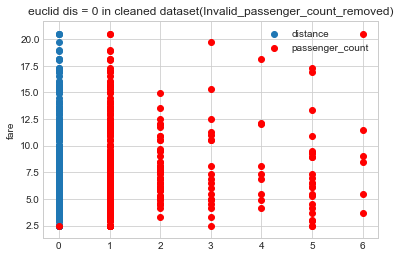

In [59]:
#plot_rides(df_cleaned[(df_cleaned.pickup_latitude==0) | (df_cleaned.pickup_longitude==0) | (df_cleaned.dropoff_latitude ==0 )|            (df_cleaned.dropoff_longitude==0)],'zero-coordinates in Invalid_passenger_count_removed')


#plot_rides(data[(data.pickup_latitude==0) | (data.pickup_longitude==0) | (data.dropoff_latitude ==0 )|            (data.dropoff_longitude==0)],'zero-coordinates in original_passenger_count_fixed')
plot_rides(data[data.euclid_dis==0],'euclid dis = 0 in original dataset')
plot_rides(df_cleaned[df_cleaned.euclid_dis==0],'euclid dis = 0 in cleaned dataset(Invalid_passenger_count_removed)')

#### both frames looks almost identical, let us continue forward with original dataframe with passenger id fixed with mode value
- let us check the fare are distrubuted, to slect a value for the distance feild

time
peaknighttime      9.422465
peakeveningtime    8.875833
noontime           8.775772
regular            8.546006
Name: fare_amount, dtype: float64


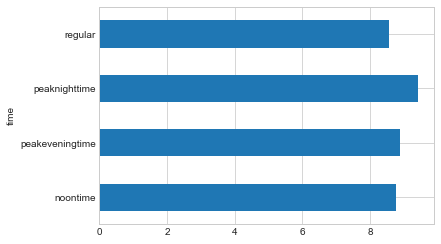

In [60]:
print(data.groupby('time')['fare_amount'].mean().nlargest(7))
data.groupby('time')['fare_amount'].mean().plot.barh()

In [61]:
data[data.euclid_dis==0].fare_amount.describe(),df_cleaned[df_cleaned.euclid_dis==0].fare_amount.describe()

(count    416.000000
 mean       7.776202
 std        3.800677
 min        2.500000
 25%        5.000000
 50%        6.900000
 75%        9.500000
 max       20.500000
 Name: fare_amount, dtype: float64, count    414.000000
 mean       7.776570
 std        3.809458
 min        2.500000
 25%        5.000000
 50%        6.900000
 75%        9.500000
 max       20.500000
 Name: fare_amount, dtype: float64)

### let us the statistics for euclid_dis where fare is in around 6.90(mean of this datset with eculid_dis=0)

In [62]:
data[(data.fare_amount>6)&(data.fare_amount<7)&(data.euclid_dis!=0)].euclid_dis.describe()

count    1605.000000
mean        0.071148
std         2.108339
min         0.000317
25%         0.013132
50%         0.016711
75%         0.020625
max        84.471214
Name: euclid_dis, dtype: float64

#### distances slighly right skewed, let us take median for the correction


Text(0.5, 1.0, 'cleaned dataframe')

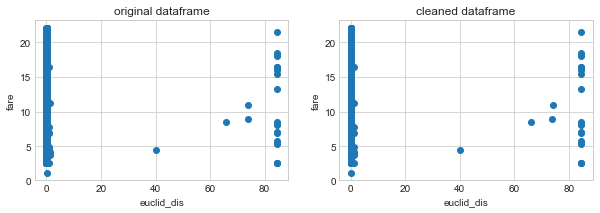

In [63]:
#Impute
#data.loc[data.euclid_dis==0,'euclid_dis'] = 6.9
#df_cleaned.loc[df_cleaned.euclid_dis==0,'euclid_dis'] = 6.9

#drop

test = test.drop(test[test.euclid_dis==0].index).reset_index().drop('index',axis=1)
df_cleaned = data.drop(data[data.euclid_dis==0].index).reset_index().drop('index',axis=1)
data.loc[data.euclid_dis==0,'euclid_dis'] = 0.017
#plt.scatter(data[data.euclid_dis<1].euclid_dis,data[data.euclid_dis<1].fare_amount)
f,ax= plt.subplots(figsize=(10,10))
pltno =321
plt.subplot(pltno)
plt.scatter(data.euclid_dis,data.fare_amount)
plt.xlabel('euclid_dis')
plt.ylabel('fare')
plt.title('original dataframe')
plt.subplot(pltno+1)
plt.scatter(df_cleaned.euclid_dis,df_cleaned.fare_amount)
plt.xlabel('euclid_dis')
plt.ylabel('fare')
plt.title('cleaned dataframe')

#### the no of observations which are differing are very small in number and hence not much visible

In [64]:
#outlier removal for distance
outlier = []
outlier,data= get_outliers(data,['euclid_dis'],outliers_=outlier,drop=False)

outlier,data= get_outliers(data,['euclid_dis'],outliers_=outlier,drop=True)
print('In original frame with passenger count fixed',outlier)
print('\n')
outlier,df_cleaned= get_outliers(df_cleaned,['euclid_dis'],outliers_=outlier,drop=True)
print('In cleaned dataframe with invalid passenger count removed',outlier)
print("\n")
outlier,test= get_outliers(test,['euclid_dis'],outliers_=outlier,drop=True)


-----values below -0.01736786771622324 and above 0.06266747620920365 suggested to drop for col euclid_dis:
-----values below -0.01736786771622324 and above 0.06266747620920365 dropped  for col euclid_dis:
In original frame with passenger count fixed ['per outliers for euclid_dis is 4.8352997340244155', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0']


-----values below -0.01861873507939933 and above 0.06421640252165343 dropped  for col euclid_dis:
In cleaned dataframe with invalid passenger count removed ['per outliers for euclid_dis is 4.8352997340244155', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0', 'per outliers for euclid_dis is 0.0']


-----values below -0.02699403324712147 and above 0.08089032705428634 dropped  for col euclid_dis:


Text(0.5, 1.0, 'cleaned dataframe')

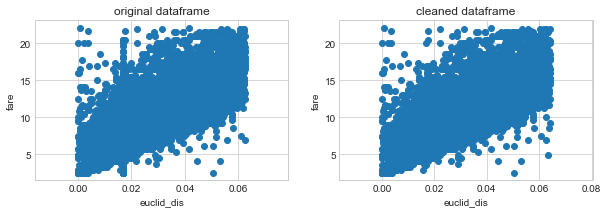

In [65]:
f,ax= plt.subplots(figsize=(10,10))
pltno =321
plt.subplot(pltno)
plt.scatter(data.euclid_dis,data.fare_amount)
plt.xlabel('euclid_dis')
plt.ylabel('fare')
plt.title('original dataframe')
plt.subplot(pltno+1)
plt.scatter(df_cleaned.euclid_dis,df_cleaned.fare_amount)
plt.xlabel('euclid_dis')
plt.ylabel('fare')
plt.title('cleaned dataframe')

In [66]:
data.corr()['fare_amount'].euclid_dis,df_cleaned.corr()['fare_amount'].euclid_dis

(0.7882853421784157, 0.8043203470920306)

### why does lesser distance result to higher prices?because of possible factors present in indepe var
- passenger_count
- time of ride
  - same distance and passenger count ,the fares are increased , there has to be a other factors which are not considered, like the Other independent factors like dropoff timestamp, waiting time, cab type(luxury/hatch back/suv).

  - But since we dont have that as independent variable to access, we will ignore these observations as they will mislead our model

In [67]:
#plt.scatter(data[data.fare_amount>10].passenger_count,data[data.fare_amount>10].fare_amount)
#plt.scatter(data[data.fare_amount>10].geodesic,data[data.fare_amount>10].fare_amount)
#data[data.fare_amount>10].groupby(['passenger_count','geodesic']).fare_amount.mean().plot.bar()
high_fare_orig = data[data.fare_amount>6.9]#['geodesic','passenger_count',]
high_fare_cleaned = df_cleaned[df_cleaned.fare_amount>6.9]

### effect of factors on high fares

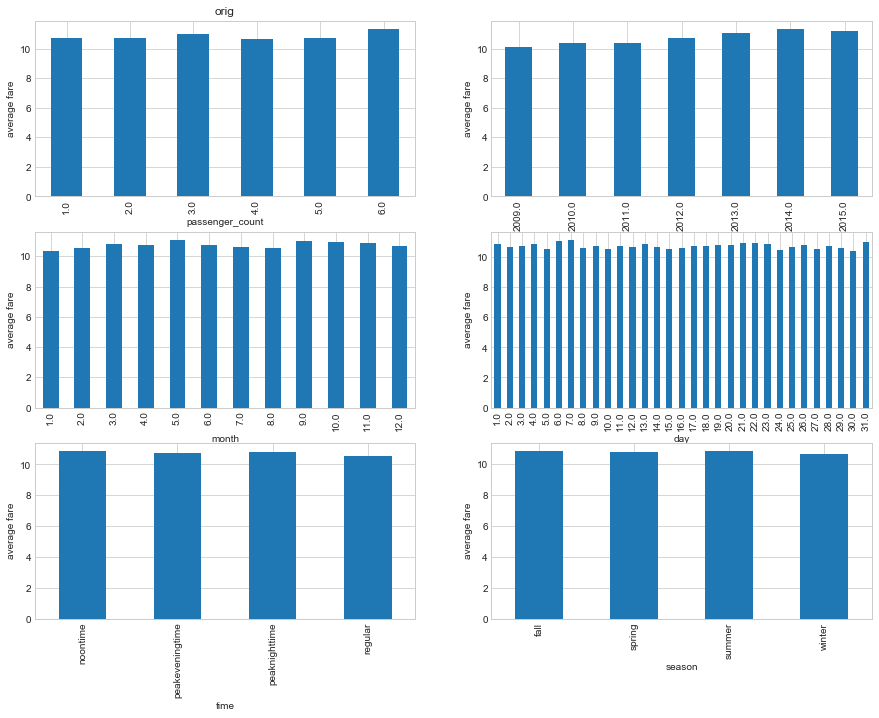

+++++++++++++++++++++++++++++++++++++++


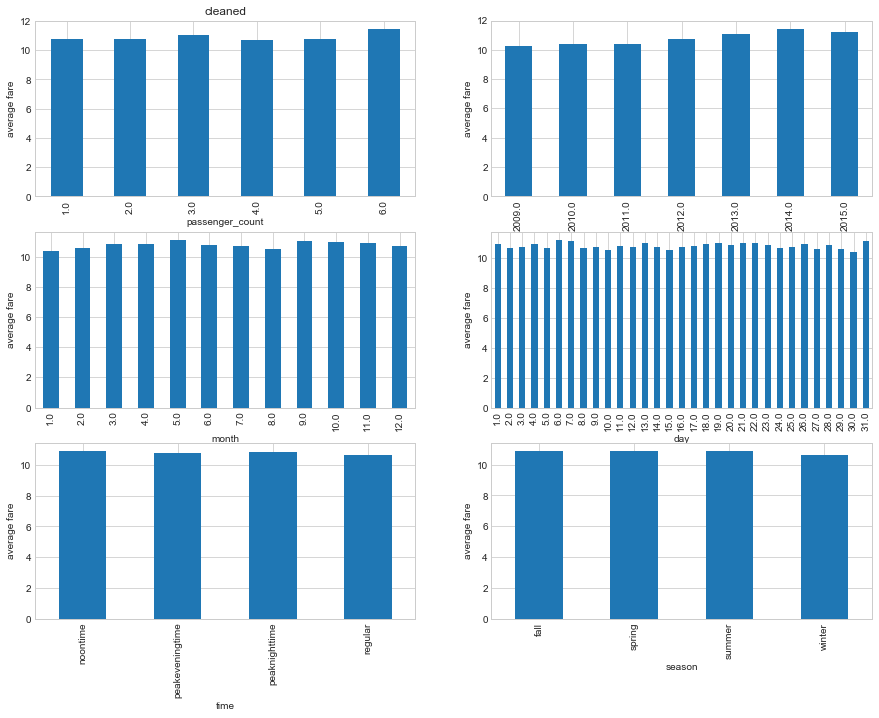

In [68]:
variation(high_fare_orig,'orig')
print('+++++++++++++++++++++++++++++++++++++++')
variation(high_fare_cleaned,'cleaned')


### cleaned dataframe gives better variations in time bar chart 
#### year effects the most
- month wise also fluctuting
- days also needs to be introspected
- passenger count 6 has highest fares
- season or time of day not effecting  the high fares

In [69]:
#??
print('After cleaning the records with more than 10 passengers, originally we had %s records'%len(df_cleaned))
print('After cleaning the records with more than 10 passengers, records with zero values in any of their coordinate values are %s'%\
      len(df_cleaned[(df_cleaned.pickup_latitude==0) | (df_cleaned.pickup_longitude==0) | (df_cleaned.dropoff_latitude ==0 )| (df_cleaned.dropoff_longitude==0)]))


After cleaning the records with more than 10 passengers, originally we had 13611 records
After cleaning the records with more than 10 passengers, records with zero values in any of their coordinate values are 0


In [70]:
data.corr()
df_cleaned.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,weekday,mahattan_dis,euclid_dis,geodesic
fare_amount,1.000000,0.016549,-0.017322,0.016883,-0.017708,0.020199,-0.012194,0.027001,0.181913,0.011686,0.778377,0.804320,0.800904
pickup_longitude,0.016549,1.000000,-0.999873,0.999977,-0.999880,-0.006539,0.013941,-0.005358,0.015591,0.001057,0.016281,0.015684,0.011080
pickup_latitude,-0.017322,-0.999873,1.000000,-0.999886,0.999969,0.006443,-0.013886,0.005429,-0.015513,-0.001901,-0.016799,-0.016275,-0.011881
dropoff_longitude,0.016883,0.999977,-0.999886,1.000000,-0.999866,-0.006563,0.013932,-0.005288,0.015628,0.001167,0.016826,0.016287,0.011598
dropoff_latitude,-0.017708,-0.999880,0.999969,-0.999866,1.000000,0.006413,-0.013792,0.005463,-0.015459,-0.001767,-0.016855,-0.016386,-0.012005
passenger_count,0.020199,-0.006539,0.006443,-0.006563,0.006413,1.000000,0.002696,0.015026,0.003036,0.046632,0.000390,0.001763,0.003198
day,-0.012194,0.013941,-0.013886,0.013932,-0.013792,0.002696,1.000000,-0.019601,-0.028256,0.008902,-0.002148,-0.002993,-0.002496
month,0.027001,-0.005358,0.005429,-0.005288,0.005463,0.015026,-0.019601,1.000000,-0.116373,-0.019004,-0.000060,-0.001803,-0.001235
year,0.181913,0.015591,-0.015513,0.015628,-0.015459,0.003036,-0.028256,-0.116373,1.000000,0.005688,0.003393,0.004383,0.004975
weekday,0.011686,0.001057,-0.001901,0.001167,-0.001767,0.046632,0.008902,-0.019004,0.005688,1.000000,0.027994,0.027765,0.029046


#### high corelation of fare_amount with geodesic, manhattanand euclidian also.
- since the euclidian distance is explaining fare price the most, we will build a model with that

### few rides with passenger count as NA also

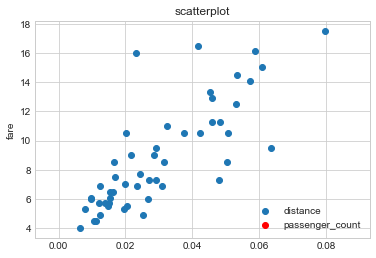

In [71]:
plot_rides(data[(data.passenger_count.isnull())])

In [72]:
data[(data.passenger_count.isnull())].euclid_dis.describe()

count    51.000000
mean      0.023528
std       0.013931
min       0.005789
25%       0.011950
50%       0.018948
75%       0.036251
max       0.057901
Name: euclid_dis, dtype: float64

In [73]:
#plt.scatter(data.geodesic,data.fare_amount)
#data[(data.geodesic<1.2)&(data.geodesic>1)].passenger_count.mode()
data[(data.fare_amount>10)].passenger_count.mode(),df_cleaned[(df_cleaned.fare_amount>10)].passenger_count.mode()

(0    1.0
 dtype: float64, 0    1.0
 dtype: float64)

In [74]:
bk=data.copy()

In [75]:
# impute passenger count
data.loc[data.passenger_count.isnull(), 'passenger_count'] = 1 #Replace passenger count to 1
# convert the data type to string, since it is a categorical variable actually
data.passenger_count = data.passenger_count.astype('int')
data.passenger_count = data.passenger_count.astype('str')

#remove these indexes in the cleaned dataframe
df_cleaned = df_cleaned.drop(df_cleaned[df_cleaned.passenger_count.isnull()].index).reset_index().drop('index',axis=1)
# convert the data type to string, since it is a categorical variable actually
df_cleaned.passenger_count = df_cleaned.passenger_count.astype('int')
df_cleaned.passenger_count = df_cleaned.passenger_count.astype('str')

In [76]:
data.corr()['fare_amount'].euclid_dis,df_cleaned.corr()['fare_amount'].euclid_dis

(0.7882853421784157, 0.8042285827427376)

In [77]:
print('After deleting the outliers from fare and distance, we have %d records/observations left,'%len(df_cleaned))
print('dropped %s percent of original data in data cleaning'%((len(data)-len(df_cleaned))/len(data)*100))

After deleting the outliers from fare and distance, we have 13560 records/observations left,
dropped 2.823563136018346 percent of original data in data cleaning


### let us remove the redundant columns now

In [78]:
model_data =df_cleaned.copy().drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','mahattan_dis','geodesic'],axis=1)
model_test = test.copy().drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','mahattan_dis','geodesic'],axis=1)

### dataframe with log transoformation on fare_amount

In [79]:
model_data_cbrt_fare = model_data.copy()
model_data_cbrt_fare['cbrt_fare'] = np.cbrt(model_data.fare_amount)

In [80]:
model_data_cbrt_fare.head(1)

,fare_amount,passenger_count,remarks,time,day,month,year,weekday,season,euclid_dis,cbrt_fare
0,4.5,1,normal,peakeveningtime,15.0,6.0,2009.0,0.0,summer,0.009436,1.650964


### adding cbrt_fare as another dependent variable 
- aim is to compare the prediction accuracy for original fare vs cbrt fare

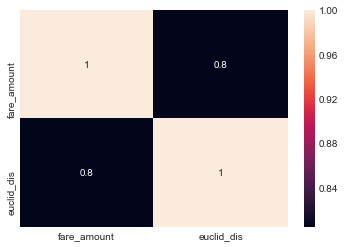

In [81]:
sb.heatmap(model_data[['fare_amount','euclid_dis']].corr(),annot=True)

### Normalization

In [82]:
#cont_names,categ_names,_,_,_ = iv_dv_get_col_names1(model_data,'fare_amount')
model_data = normalize(model_data,['month','weekday','day','euclid_dis'])
model_test = normalize(model_test,['month','weekday','day','euclid_dis'])

### boxcox transformation

In [83]:
data_norm, test_norm,fitted_lambdas = boxcox_normalization(data.drop(['pickup_datetime','pickup_longitude',\
                            'pickup_latitude','dropoff_latitude','dropoff_longitude','mahattan_dis','geodesic'],axis=1),\
                                             ['euclid_dis','month','day'],\
                                             test,['euclid_dis','month','day'])

data.head()

euclid_dis
Applying 0.38862773277044327 to euclid_dis in test
month
Applying 0.6282280797671168 to month in test
day
Applying 0.7267413616338717 to day in test


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,remarks,time,day,month,year,weekday,season,mahattan_dis,euclid_dis,geodesic
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,normal,peakeveningtime,15.0,6.0,2009.0,0.0,summer,0.011742,0.009436,0.639764
1,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,normal,peaknighttime,18.0,8.0,2011.0,3.0,fall,0.019212,0.013674,0.863167
2,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,normal,peaknighttime,21.0,4.0,2012.0,5.0,spring,0.029386,0.025340,1.737223
3,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,normal,regular,9.0,3.0,2010.0,1.0,spring,0.027194,0.019470,1.241710
4,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,normal,regular,6.0,1.0,2011.0,3.0,winter,0.054675,0.038675,2.353742


In [84]:
data_norm.head(1)

,fare_amount,passenger_count,remarks,time,year,weekday,season,euclid_dis,month,day
0,4.5,1,normal,peakeveningtime,2009.0,0.0,summer,-2.153001,3.314352,8.471683


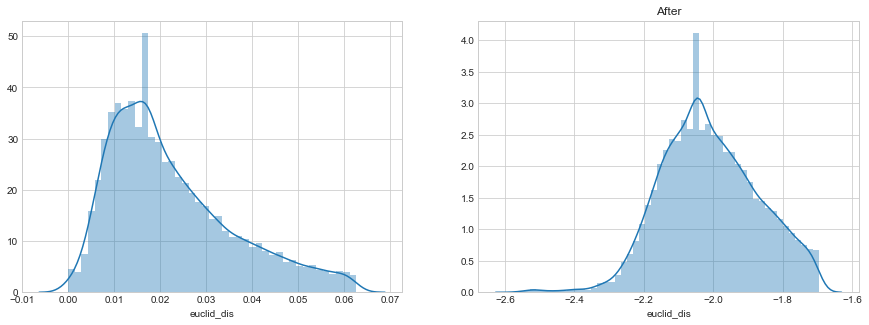

In [85]:

f,ax=plt.subplots(1,2,figsize=(15,5))
plt.title('before')
#sb.distplot(data.fare_amount,ax=ax[0],label='Before')
#plt.legend()
sb.distplot(data.euclid_dis,ax=ax[0],label='Before')


#sb.distplot(data_norm.fare_amount,ax=ax[2],label='After')
plt.title('After')
#plt.legend()
sb.distplot(data_norm.euclid_dis,ax=ax[1],label ='After boxcox transformation')
#plt.legend()
plt.show()

## chi-sq analysis

In [86]:
continous_names, cat_names, iv,dv,testparams = iv_dv_get_col_names_dist_based(model_data,'fare_amount')
continous_names, cat_names

Need to define this col - passenger_count in categ variable
Need to define this col - remarks in categ variable
Need to define this col - time in categ variable
Need to define this col - month in categ variable
Need to define this col - year in categ variable
Need to define this col - weekday in categ variable
Need to define this col - season in categ variable


(['fare_amount',
  'passenger_count',
  'remarks',
  'time',
  'day',
  'month',
  'year',
  'weekday',
  'season',
  'euclid_dis'],
 [])

In [87]:
model_data.columns

Index(['fare_amount', 'passenger_count', 'remarks', 'time', 'day', 'month',
       'year', 'weekday', 'season', 'euclid_dis'],
      dtype='object')

In [88]:
model_data,skip = chi_sq_analysis(model_data,model_data.drop(['fare_amount','euclid_dis','month','weekday','day'],axis=1).columns,'fare_amount',drop=False)
#test = chi_sq_analysis1(test,['time','passenger_count'])


Suggest to skip col below---------------------
skip -p value 0.322496 passenger_count
skip -p value 0.211098 remarks
accept -pvalue 0.000003 time
accept -pvalue 0.000000 year
accept -pvalue 0.000036 season


#### chi2 analysis suggests that passenger count is insignificant and independent from target fare_price, we will create 2 models for testing

In [89]:
model_data.to_csv(processed_data_path,index=False)
#model_data = pd.read_csv(processed_data_path)

In [90]:
#model_data=model_data.drop('log_fare',axis=1)
model_data.head(2)


,fare_amount,passenger_count,remarks,time,day,month,year,weekday,season,euclid_dis
0,4.5,1,normal,peakeveningtime,0.466667,0.454545,2009.0,0.0,summer,0.147025
1,5.7,2,normal,peaknighttime,0.566667,0.636364,2011.0,0.5,fall,0.213069


In [91]:
model_data_orig = pd.get_dummies(model_data,drop_first=True,columns=['year','passenger_count','remarks','time','season'])
model_data_chi2 = pd.get_dummies(model_data.drop(skip,axis=1),drop_first=True,columns=['year','time','season'])
model_data_cbrt_fare = pd.get_dummies(model_data_cbrt_fare.drop('fare_amount',axis=1),drop_first=True,columns=['year','passenger_count','remarks','time','season'])
model_data_boxcox = pd.get_dummies(data_norm,drop_first=True,columns=['year','passenger_count','remarks','time','season'])
model_test = pd.get_dummies(model_test,drop_first=True,columns=['year','passenger_count','remarks','time','season'])

In [92]:
#data_norm=data_norm.drop('pickup_datetime',axis=1)
#model_data_boxcox = pd.get_dummies(data_norm,drop_first=True,columns=['year','passenger_count','remarks','time','season'])
#model=LinearRegression().fit(model_data_boxcox.drop('fare_amount',axis=1),model_data_boxcox['fare_amount'])
#model.score(model_data_boxcox.drop('fare_amount',axis=1),model_data_boxcox['fare_amount'])

In [93]:
model_data_orig.head(1)

,fare_amount,day,month,weekday,euclid_dis,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,...,passenger_count_5,passenger_count_6,remarks_month_start,remarks_normal,time_peakeveningtime,time_peaknighttime,time_regular,season_spring,season_summer,season_winter
0,4.5,0.466667,0.454545,0.0,0.147025,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [94]:
model_data_chi2.head(1)

,fare_amount,day,month,weekday,euclid_dis,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,time_peakeveningtime,time_peaknighttime,time_regular,season_spring,season_summer,season_winter
0,4.5,0.466667,0.454545,0.0,0.147025,0,0,0,0,0,0,1,0,0,0,1,0


In [95]:
model_data_cbrt_fare.head(1)

,day,month,weekday,euclid_dis,cbrt_fare,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,...,passenger_count_5,passenger_count_6,remarks_month_start,remarks_normal,time_peakeveningtime,time_peaknighttime,time_regular,season_spring,season_summer,season_winter
0,15.0,6.0,0.0,0.009436,1.650964,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [96]:
model_data_boxcox.head(1)

,fare_amount,weekday,euclid_dis,month,day,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,...,passenger_count_5,passenger_count_6,remarks_month_start,remarks_normal,time_peakeveningtime,time_peaknighttime,time_regular,season_spring,season_summer,season_winter
0,4.5,0.0,-2.153001,3.314352,8.471683,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [97]:
model_test.head(1)

,day,month,weekday,euclid_dis,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,...,passenger_count_5.0,passenger_count_6.0,remarks_month_start,remarks_normal,time_peakeveningtime,time_peaknighttime,time_regular,season_spring,season_summer,season_winter
0,0.866667,0.0,0.166667,0.266367,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Model creation

### randomforest hyperparameter tuning
rf_hyperparameter_tuning runs the randomforest regressor with different value of estiamtor trees , max features to build the trees adnd returns the best values in rf_params dictionary

--------------------random forest pramaeter tuning------------------


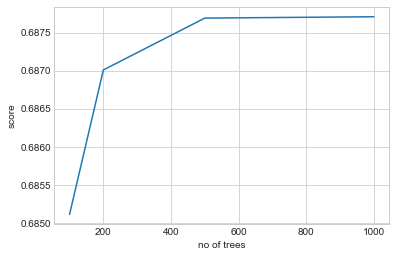

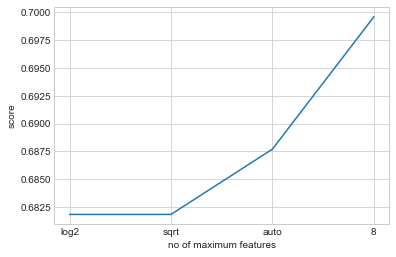

In [98]:
## get the tuned paramters
SEED =0
NFOLDS=5
rf_params={}

#rf_params = {
#    'n_estimators': 1000,
#   'max_features':'auto'
#}

iv = model_data_orig.drop('fare_amount',axis=1)
dv = model_data_orig['fare_amount']
rf_params = rf_hyperparameter_tuning(iv,dv,rf_params)


### knn hyperparameter tuning
knn_k_tunin runs the KNeighborsRegressor with different value of k , and returns the best k value which results in lowest root mean square error

-------------------------------KNN neighbors tuning---------------
rmse error for k 1 is 3.552127743258226
rmse error for k 2 is 3.1440579740009658
rmse error for k 3 is 3.010992053136496
rmse error for k 4 is 2.9421461467974432
rmse error for k 5 is 2.9174543928257544
rmse error for k 6 is 2.9150546075297403
rmse error for k 7 is 2.911619327546534
rmse error for k 8 is 2.9111708871841975
rmse error for k 9 is 2.92962313375218
rmse error for k 10 is 2.9341295507987044
rmse error for k 11 is 2.9408510650861275
rmse error for k 12 is 2.9457542280507427
rmse error for k 13 is 2.954618783895606
rmse error for k 14 is 2.9616894586724825
{1: 3.552127743258226, 2: 3.1440579740009658, 3: 3.010992053136496, 4: 2.9421461467974432, 5: 2.9174543928257544, 6: 2.9150546075297403, 7: 2.911619327546534, 8: 2.9111708871841975, 9: 2.92962313375218, 10: 2.9341295507987044, 11: 2.9408510650861275, 12: 2.9457542280507427, 13: 2.954618783895606, 14: 2.9616894586724825}


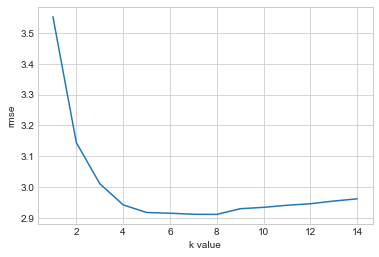

In [99]:
iv = model_data_orig.drop('fare_amount',axis=1)
dv = model_data_orig['fare_amount']
knn_params={}
knn_params = knn_k_tuning(iv,dv,knn_params)

### LinearRegression varaince check

In [100]:
model_data_orig.columns

Index(['fare_amount', 'day', 'month', 'weekday', 'euclid_dis', 'year_2010.0',
       'year_2011.0', 'year_2012.0', 'year_2013.0', 'year_2014.0',
       'year_2015.0', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'remarks_month_start', 'remarks_normal', 'time_peakeveningtime',
       'time_peaknighttime', 'time_regular', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [101]:
vif = pd.DataFrame()
predictors = model_data_orig.drop(['fare_amount'],axis=1)
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,4.540402,day
1,3.841892,month
2,3.313969,weekday
3,3.579799,euclid_dis
4,1.882340,year_2010.0
5,1.866023,year_2011.0
6,1.896685,year_2012.0
7,1.881011,year_2013.0
8,1.802881,year_2014.0
9,1.450629,year_2015.0


In [102]:
#### need to remove passenger_count1 from the predictors
#model_data_boxcox.corr()['fare_amount']
model_data_boxcox.columns

Index(['fare_amount', 'weekday', 'euclid_dis', 'month', 'day', 'year_2010.0',
       'year_2011.0', 'year_2012.0', 'year_2013.0', 'year_2014.0',
       'year_2015.0', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'remarks_month_start', 'remarks_normal', 'time_peakeveningtime',
       'time_peaknighttime', 'time_regular', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [103]:
vif = pd.DataFrame()
predictors = model_data_boxcox.drop(['fare_amount'],axis=1)
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,3.441159,weekday
1,40.043534,euclid_dis
2,5.407463,month
3,8.319285,day
4,1.988734,year_2010.0
5,1.979074,year_2011.0
6,2.001019,year_2012.0
7,1.987537,year_2013.0
8,1.894652,year_2014.0
9,1.509057,year_2015.0


#### since the vif for euclid dis is so large, we can't use this, and hence dropping this for evaluation

## Get the objects for different models 

In [104]:
rf = sklearnHelper(clf = RandomForestRegressor, seed = SEED,params = rf_params)
lr = sklearnHelper(clf = LinearRegression, seed = SEED,params= None)
knn = sklearnHelper(clf=KNeighborsRegressor, seed=SEED, params=knn_params)

In [105]:

iv = model_data_orig.drop(['fare_amount'],axis=1).values
dv = model_data_orig['fare_amount']

print('-------------------------')
print('linearRegression--------')
print('-------------------------')
lr_avg_score, lr_auc_score,lr_rmse_score,logger= get_score(model_data_orig, lr, iv, dv,regression=True)
print('++++++++++ Average lr score : %s, Average lr rmse score : %s'%(lr_avg_score,lr_rmse_score))

print('-------------------------')
print('RandomForestRegressor-----')
print('-------------------------')
rf_avg_score,rf_auc_score,rf_rmse_score,logger = get_score(model_data_orig, rf, iv, dv,regression=True)
print('++++++++ Average rf score : %s, Average rf rmse score : %s'%( rf_avg_score,rf_rmse_score))

print('-------------------------')
print('KNN ------------------------')
print('-------------------------')
knn_avg_score,knn_auc_score,knn_rmse_score,logger = get_score(model_data_orig, knn, iv, dv,regression=True)
print('++++++++ Average rf score : %s, Average rf rmse score : %s'%( knn_avg_score,knn_rmse_score))




-------------------------
linearRegression--------
-------------------------
model score : 0.6902747154013693
rmse : 2.075360721005225
model score : 0.6975236291292488
rmse : 2.044410394681389
model score : 0.6843799934089876
rmse : 2.0371463798352174
model score : 0.699649207515128
rmse : 2.0763012776563254
model score : 0.6900182411742742
rmse : 2.0734075032566057
++++++++++ Average lr score : 0.6923691573258016, Average lr rmse score : 2.0613252552869525
-------------------------
RandomForestRegressor-----
-------------------------
model score : 0.6939177310342499
rmse : 2.0631193321541765
model score : 0.7004298062443777
rmse : 2.0345653960974195
model score : 0.6810278257744143
rmse : 2.0479359678361897
model score : 0.6912374534684157
rmse : 2.1051754036212014
model score : 0.6863861577416641
rmse : 2.085519276608105
++++++++ Average rf score : 0.6905997948526243, Average rf rmse score : 2.0672630752634182
-------------------------
KNN ------------------------
-------------------

Index(['month', 'euclid_dis', 'year_2012.0', 'year_2013.0', 'year_2014.0',
       'year_2015.0', 'passenger_count_3', 'passenger_count_6',
       'time_peakeveningtime', 'time_peaknighttime', 'time_regular'],
      dtype='object') [ 0.60148521 13.83731096  0.530654    1.37711184  1.58483376  1.98023892
  0.38760849  0.17114656 -0.37979178 -0.84845151 -0.48771199]
LR R2 score : 0.7034488956042176
Adjusted R2 Score : 0.7032081174710372
+++++++++accuracy : 82.50318824917441
----------MAPE : %s 17.49681175082559
---------RMSE %s 2.0272569932983


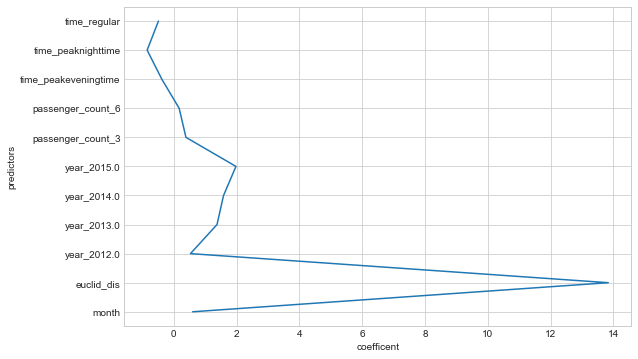

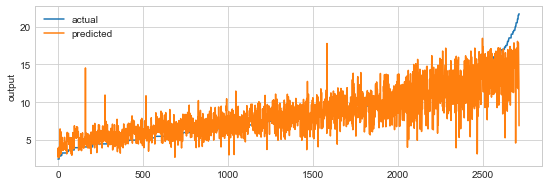

In [106]:
iv = model_data_orig.drop(['fare_amount','weekday','day','remarks_normal','season_spring','remarks_month_start',
       'season_summer', 'season_winter','year_2010.0', 'year_2011.0','passenger_count_2', 'passenger_count_4',
        'passenger_count_5'],axis=1)
dv = model_data_orig['fare_amount']
plot_lr_coef(iv,dv)

accuracy  0.6801997528944859


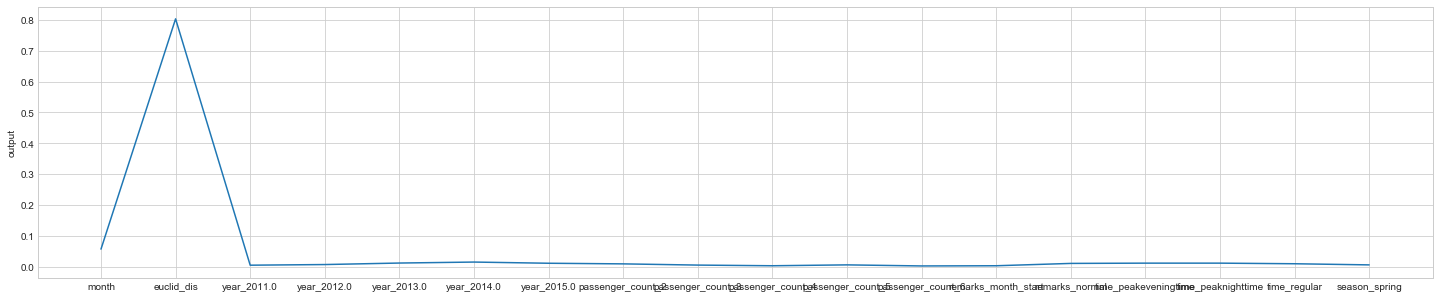

In [107]:
iv = model_data_orig.drop(['fare_amount','weekday','day','year_2010.0','season_winter','season_summer'],axis=1)
dv = model_data_orig['fare_amount']
plot_rf_feature_importance(iv,dv,rf_params)

In [108]:

iv = model_data_chi2.drop('fare_amount',axis=1).values
dv = model_data_chi2['fare_amount']

print('-------------------------')
print('linearRegression--------')
print('-------------------------')
lr_avg_score, lr_auc_score,lr_rmse_score,logger= get_score(model_data_chi2, lr, iv, dv,regression=True)
print('+++++++++++++++Average lr score : %s, Average lr rmse score : %s'%(lr_avg_score,lr_rmse_score))

print('-------------------------')
print('RandomForestRegressor-----')
print('-------------------------')
rf_avg_score,rf_auc_score,rf_rmse_score,logger = get_score(model_data_chi2, rf, iv, dv,regression=True)
print('+++++++++Average rf score : %s, Average rf rmse score : %s'%( rf_avg_score,rf_rmse_score))

print('-------------------------')
print('KNN ------------------------')
print('-------------------------')
knn_avg_score,knn_auc_score,knn_rmse_score,logger = get_score(model_data_chi2, knn, iv, dv,regression=True)
print('++++++++ Average rf score : %s, Average rf rmse score : %s'%( knn_avg_score,knn_rmse_score))




-------------------------
linearRegression--------
-------------------------
model score : 0.6899450808290293
rmse : 2.0764648102629084
model score : 0.6966798539293797
rmse : 2.0472599089209926
model score : 0.6841263016097264
rmse : 2.037964933016907
model score : 0.6994317965925652
rmse : 2.0770526139737258
model score : 0.6896161719533984
rmse : 2.0747517487861593
+++++++++++++++Average lr score : 0.6919598409828197, Average lr rmse score : 2.0626988029921387
-------------------------
RandomForestRegressor-----
-------------------------
model score : 0.6926528728933778
rmse : 2.0673777671660347
model score : 0.6965810032569466
rmse : 2.047593478147824
model score : 0.6812278289828573
rmse : 2.047293814658307
model score : 0.6908193310869998
rmse : 2.1066003224925023
model score : 0.6853255789007524
rmse : 2.0890427032883188
+++++++++Average rf score : 0.6893213230241868, Average rf rmse score : 2.0715816171505974
-------------------------
KNN ------------------------
--------------

In [110]:

iv = model_data_cbrt_fare.drop('cbrt_fare',axis=1).values
dv = model_data_cbrt_fare['cbrt_fare']

print('-------------------------')
print('linearRegression--------')
print('-------------------------')
lr_avg_score, lr_auc_score,lr_rmse_score,logger= get_score(model_data_cbrt_fare, lr, iv, dv,regression=True)
print('+++++++++++++++Average lr score : %s, Average lr rmse score : %s'%(lr_avg_score,lr_rmse_score))

print('-------------------------')
print('RandomForestRegressor-----')
print('-------------------------')
rf_avg_score,rf_auc_score,rf_rmse_score,logger = get_score(model_data_cbrt_fare, rf, iv, dv,regression=True)
print('+++++++++Average rf score : %s, Average rf rmse score : %s'%( rf_avg_score,rf_rmse_score))

print('-------------------------')
print('KNN ------------------------')
print('-------------------------')
knn_avg_score,knn_auc_score,knn_rmse_score,logger = get_score(model_data_cbrt_fare, knn, iv, dv,regression=True)
print('++++++++ Average rf score : %s, Average rf rmse score : %s'%( knn_avg_score,knn_rmse_score))



-------------------------
linearRegression--------
-------------------------
model score : 0.6960485544232093
rmse : 0.15684190783696597
model score : 0.7076508771288721
rmse : 0.15347602713132844
model score : 0.6903283924978474
rmse : 0.15609106145385848
model score : 0.7074529267304605
rmse : 0.1539529204347498
model score : 0.7027370235372717
rmse : 0.1543951573259523
+++++++++++++++Average lr score : 0.7008435548635321, Average lr rmse score : 0.154951414836571
-------------------------
RandomForestRegressor-----
-------------------------
model score : 0.7105398445674442
rmse : 0.1530574259669879
model score : 0.7185886699152271
rmse : 0.15057762413222442
model score : 0.6964904600337846
rmse : 0.15453025201997364
model score : 0.7032255650482687
rmse : 0.1550612555909901
model score : 0.7099543705107354
rmse : 0.15250933459481134
+++++++++Average rf score : 0.707759782015092, Average rf rmse score : 0.15314717846099749
-------------------------
KNN ------------------------
------

#### Model with cube root fare_amount, shows the highest score and least rmse

In [111]:

iv = model_data_boxcox.drop(['fare_amount'],axis=1).values
dv = model_data_boxcox['fare_amount']

print('-------------------------')
print('linearRegression--------')
print('-------------------------')
lr_avg_score, lr_auc_score,lr_rmse_score,logger= get_score(model_data_boxcox, lr, iv, dv,regression=True)
print('+++++++++++++++Average lr score : %s, Average lr rmse score : %s'%(lr_avg_score,lr_rmse_score))

print('-------------------------')
print('RandomForestRegressor-----')
print('-------------------------')
rf_avg_score,rf_auc_score,rf_rmse_score,logger = get_score(model_data_boxcox, rf, iv, dv,regression=True)
print('+++++++++Average rf score : %s, Average rf rmse score : %s'%( rf_avg_score,rf_rmse_score))

print('-------------------------')
print('KNN ------------------------')
print('-------------------------')
knn_avg_score,knn_auc_score,knn_rmse_score,logger = get_score(model_data_orig, knn, iv, dv,regression=True)
print('++++++++ Average rf score : %s, Average rf rmse score : %s'%( knn_avg_score,knn_rmse_score))




-------------------------
linearRegression--------
-------------------------
model score : 0.6269803689076493
rmse : 2.2585544625118197
model score : 0.6302672553236751
rmse : 2.248454559522805
model score : 0.6252244141293652
rmse : 2.1993835284713876
model score : 0.6262512431014975
rmse : 2.2857040374811377
model score : 0.6227864180489227
rmse : 2.2648362929652874
+++++++++++++++Average lr score : 0.6263019399022219, Average lr rmse score : 2.2513865761904874
-------------------------
RandomForestRegressor-----
-------------------------
model score : 0.6656488844452297
rmse : 2.1382875715835428
model score : 0.6686315111843313
rmse : 2.1286083492196877
model score : 0.6583976837562465
rmse : 2.0997893358165856
model score : 0.6663668349721014
rmse : 2.159557265005461
model score : 0.649116236986222
rmse : 2.1843628961973276
+++++++++Average rf score : 0.6616322302688261, Average rf rmse score : 2.142121083564521
-------------------------
KNN ------------------------
---------------

## rmse is least when cube root fares were used
-- neglecting day,weekday gives the best 0.70 score for this data

In [112]:

iv = model_data_orig.drop(['fare_amount','weekday','day','year_2010.0','season_winter','season_summer'],axis=1)
dv = model_data_orig['fare_amount']
cmp_model(iv,dv)


LinearRegression: r2 0.6936266698744884 vif : 3.263991678356374
ols: r2 0.6936266698744883 vif : 3.263991678356374


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1703.
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        15:25:23   Log-Likelihood:                -29029.
No. Observations:               13560   AIC:                         5.810e+04
Df Residuals:                   13541   BIC:                         5.824e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9239      0.073     40.084      0.000       2.781       3.067
month                    0.6484      0.062     10.421      0.000       0.526       0.770
euclid_dis              13.8394      0.081    169.820      0.000      13.680      13.999
year_2011.0              0.0657      0.055      1.199      0.231      -0.042       0.173
year_2012.0              0.5129      0.055      9.399      0.000       0.406       0.620
year_2013.0              1.4020      0.055     25.555      0.000       1.294       1.510
year_2014.0              1.6123      0.057     28.462      0.000       1.501       1.723
year_2015.0              1.9954      0.075     26.526      0.000       1.848       2.143
passenger_count_2        0.1197      0.052      2.323      0.020       0.019       0.221
passenger_count_3        0.3595      0.089      4.045      0.000       0.185       0.534
passenger_count_4        0.1898      0.126      1.505      0.132      -0.057       0.437
passenger_count_5        0.1595      0.072      2.204      0.028       0.018       0.301
passenger_count_6        0.2426      0.129      1.875      0.061      -0.011       0.496
remarks_month_start      0.1727      0.109      1.579      0.114      -0.042       0.387
remarks_normal           0.0520      0.048      1.095      0.274      -0.041       0.145
time_peakeveningtime    -0.3942      0.047     -8.465      0.000      -0.486      -0.303
time_peaknighttime      -0.9135      0.051    -17.802      0.000      -1.014      -0.813
time_regular            -0.5166      0.051    -10.092      0.000      -0.617      -0.416
season_spring            0.0329      0.049      0.667      0.505      -0.064       0.130
==============================================================================
Omnibus:                     4361.875   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22679.300
Skew:                           1.462   Prob(JB):                         0.00
Kurtosis:                       8.621   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### looking at the p value, remarks_month_start,remarks_normal,season_Spring,passenger_count_4, year_2011 is not significant since p-value is greater than 0.05, sttaing that we fail to reject the null hypothesis and these variables are independent wrt our target fare_amount
- LinearRegression gives overall best results
- with cube root of fare_Amount, random forest is little better

## Predict for the test records

In [113]:
iv = model_data_cbrt_fare.drop(['cbrt_fare'],axis=1)
dv = model_data_cbrt_fare['cbrt_fare']
iv_test = model_test
model = LinearRegression().fit(iv,dv)#using all records for training now
dv_test_pred = model.predict(iv_test)#predict test records
iv_test['fare_amount'] = pow(dv_test_pred,(3))#converting back

#write back the results
iv_test.to_csv(submitted_data_path,index=False)
